# Text Classification Application: Fake News detection
* Author: Johannes Maucher and Marcel Heisler
* Last update: 13.12.2022

In this notebook conventional Machine Learning algorithms are applied to learn a discriminator-model for distinguishing fake- and non-fake news.

What you will learn:
* Access text from .csv file
* Preprocess text for classification
* Calculate BoW matrix
* Apply conventional machine learning algorithms for fake news detection
* Evaluation of classifiers

## Access Data
In this notebook a [fake-news corpus from Kaggle](https://www.kaggle.com/c/fake-news/data) is applied for training and testing Machine Learning algorithms. Download the train file and save it in a directory. Load it into a pandas dataframe.

Then inspect the data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB

In [2]:
data = pd.read_csv('../Data/fake-news/train.csv',index_col=0)
print(data.shape)
data.head()

(20800, 4)


title              author  \
id                                                                          
0   House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2                   Why the Truth Might Get You Fired  Consortiumnews.com   
3   15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                 text  label  
id                                                            
0   House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1   Ever get the feeling your life circles the rou...      0  
2   Why the Truth Might Get You Fired October 29, ...      1  
3   Videos 15 Civilians Killed In Single US Airstr...      1  
4   Print \nAn Iranian woman has been sentenced to...      1

Above we see that we have 20800 documents (rows in the dataframe) and for each document we (should) have a title, the author the text and a label.

Below we can see that the dataset seems to be pretty balanced with about 10400 documents belonging to each category.

In [3]:
bins, counts = np.unique(data.label, return_counts=True)
print(bins, counts)

[0 1] [10387 10413]


If we check for missing values we can find them in each of the columns except for the label.

In [4]:
data.isnull().sum(axis=0)

title      558
author    1957
text        39
label        0
dtype: int64

## Data Preparation

In the following code cells, we rearrange the input texts. First we replace missing values with spaces (`' '`). Then we concatenate `title`, `author` and `text` to a single column of text, called `total`. So far the operations can be applied to *train* and *test* data at once. Now we need to split the data and process each set independently.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
data = data.fillna(' ')
data['total'] = data['title'] + ' ' + data['author'] + ' ' + data['text']

In [7]:
data = data[['total', 'label']]
data.head()

total  label
id                                                          
0   House Dem Aide: We Didn’t Even See Comey’s Let...      1
1   FLYNN: Hillary Clinton, Big Woman on Campus - ...      0
2   Why the Truth Might Get You Fired Consortiumne...      1
3   15 Civilians Killed In Single US Airstrike Hav...      1
4   Iranian woman jailed for fictional unpublished...      1

## Preprocessing
The input texts in column `total` shall be preprocessed as follows:
* stopwords shall be removed
* all characters, which are neither alpha-numeric nor whitespaces, shall be removed
* all characters shall be represented in lower-case.
* for all words, the lemma (base-form) shall be applied

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [9]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [10]:
for index in data.index:
    sentence = data.loc[index,'total']
    # Cleaning the sentence with regex
    sentence = re.sub(r'[^\w\s]', '', sentence)
    # Tokenization
    words = nltk.word_tokenize(sentence)
    # Stopwords removal
    words = [lemmatizer.lemmatize(w).lower() for w in words if not w in stop_words]
    filter_sentence = " ".join(words)
    data.loc[index, 'total'] = filter_sentence

First 5 cleaned texts in the training-dataframe:

In [11]:
data.head()

total  label
id                                                          
0   house dem aide we didnt even see comeys letter...      1
1   flynn hillary clinton big woman campus breitba...      0
2   why truth might get you fired consortiumnewsco...      1
3   15 civilians killed in single us airstrike hav...      1
4   iranian woman jailed fictional unpublished sto...      1

Clean data in the test-dataframe in the same way as done for the training-dataframe above:

First 5 cleaned texts in the test-dataframe:

## Determine Bag-of-Word Matrix for Training- and Test-Data
In the code-cells below two different types of Bag-of-Word matrices are calculated. The first type contains the **term-frequencies**, i.e. the entry in row $i$, column $j$ is the frequency of word $j$ in document $i$. In the second type, the matrix-entries are not the term-frequencies, but the **tf-idf-values**. 

We also need to split the data now into train and test. Then for a each type of matrix (term-frequency or tf-idf) a separate one must be calculated for training and testing. Since we always pretend, that only training-data is known in advance, the matrix-structure, i.e. the columns (= words) depends only on the training-data. This matrix structure is calculated in the row:

```
count_vectorizer.fit(X_train)
```
and
```
tfidf.fit(freq_term_matrix_train),
```
respectively. An important parameter of the `CountVectorizer`-class is `min_df`. The value, which is assigned to this parameter is the minimum frequency of a word, such that it is regarded in the BoW-matrix. Words, which appear less often are disregarded.

The training data is then mapped to this structure by 
```
count_vectorizer.transform(X_train)
```
and
```
tfidf.transform(X_train),
```
respectively.

For the test-data, however, no new matrix-structure is calculated. Instead the test-data is transformed to the structure of the matrix, defined by the training data.

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(data['total'], data['label'], train_size=0.8, random_state=1) 
print('Training data size: {}'.format(len(train_data)))
print('Test data size: {}'.format(len(test_data)))
train_data = train_data.values
test_data = test_data.values
train_labels = train_labels.values
test_labels = test_labels.values

Training data size: 16640
Test data size: 4160


Train BoW-models and transform training-data to BoW-matrix:

In [14]:
count_vectorizer = CountVectorizer(min_df=4)
count_vectorizer.fit(train_data)
freq_term_matrix_train = count_vectorizer.transform(train_data)
tfidf = TfidfTransformer(norm = "l2")
tfidf.fit(freq_term_matrix_train)
tf_idf_matrix_train = tfidf.transform(freq_term_matrix_train)

In [15]:
print(freq_term_matrix_train.toarray().shape)
print(tf_idf_matrix_train.toarray().shape)

(16640, 49086)
(16640, 49086)


Transform test-data to BoW-matrix:

In [16]:
freq_term_matrix_test = count_vectorizer.transform(test_data)
tf_idf_matrix_test = tfidf.transform(freq_term_matrix_test)

## Train a Naive Bayes calssifier

We train on *term-frequencies* first, make predictions on the test set with this classifier and calculate the accuracy. Then we compare to the usage of *tf-idf-values*.

In [17]:
nb_tf_classifier = MultinomialNB()
nb_tf_classifier.fit(freq_term_matrix_train, train_labels)
nb_tf_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [18]:
tf_predictions = nb_tf_classifier.predict(freq_term_matrix_test)
accuracy_score(test_labels, tf_predictions)

0.9276442307692307

In [19]:
nb_tfidf_classifier = MultinomialNB()
nb_tfidf_classifier.fit(tf_idf_matrix_train, train_labels)
tfidf_predictions = nb_tfidf_classifier.predict(tf_idf_matrix_test)
accuracy_score(test_labels, tfidf_predictions)

0.9055288461538461

## Further evaluation

In [20]:
print(classification_report(test_labels, tfidf_predictions))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2038
           1       0.99      0.83      0.90      2122

    accuracy                           0.91      4160
   macro avg       0.92      0.91      0.91      4160
weighted avg       0.92      0.91      0.91      4160



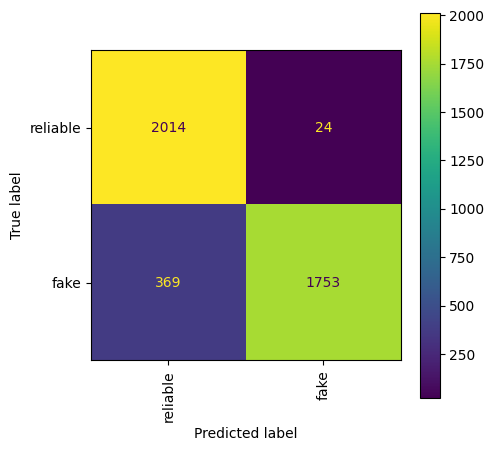

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_estimator(nb_tfidf_classifier, tf_idf_matrix_test, test_labels, display_labels=['reliable', 'fake'], xticks_rotation='vertical', ax=ax)
#disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, tf_idf_matrix_test, test_labels, normalize='true', display_labels=['reliable', 'fake'], xticks_rotation='vertical', ax=ax)

## Train a linear classifier

Below a [Logistic Regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) is trained. This is just a linear classifier with a sigmoid- or softmax- activation-function. 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2038
           1       0.96      0.97      0.97      2122

    accuracy                           0.97      4160
   macro avg       0.97      0.97      0.97      4160
weighted avg       0.97      0.97      0.97      4160



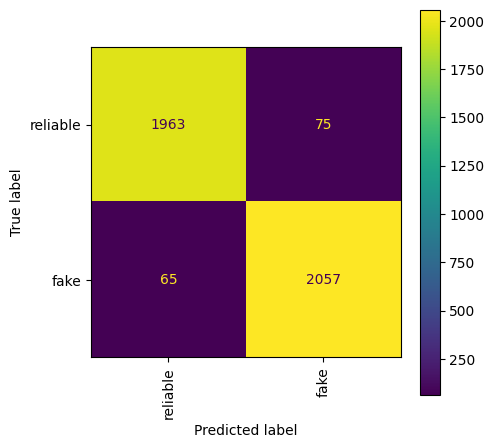

In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(tf_idf_matrix_train, train_labels)

logreg_predictions = logreg.predict(tf_idf_matrix_test)

print(classification_report(test_labels, logreg_predictions))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_estimator(logreg, tf_idf_matrix_test, test_labels, display_labels=['reliable', 'fake'], xticks_rotation='vertical', ax=ax)

Note: there is an acutal test set provided by the kaggle challenge. However it seems that the distribution of test-data is significantly different from the distribution of training-data. Since similar preprocessing an classifiers resultet in much worse evaluation scores (about 0.65 Accuracy). This is why we only used the official train data and splittet it to get meaningful results.

Results of a logistic regression model on the actual `test.csv`:

              precision    recall  f1-score   support

           0       0.59      0.65      0.62      2339
           1       0.69      0.63      0.66      2861

    accuracy                           0.64      5200
    macro avg       0.64      0.64      0.64      5200
    weighted avg       0.64      0.64      0.64      5200